In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook

rc('animation', html='html5')
rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{bm}']}
plt.rcParams.update(params)
fontsize = 40
PWD = os.getcwd()

ShearJefferyProblem: run 10001 loops using 2.259679


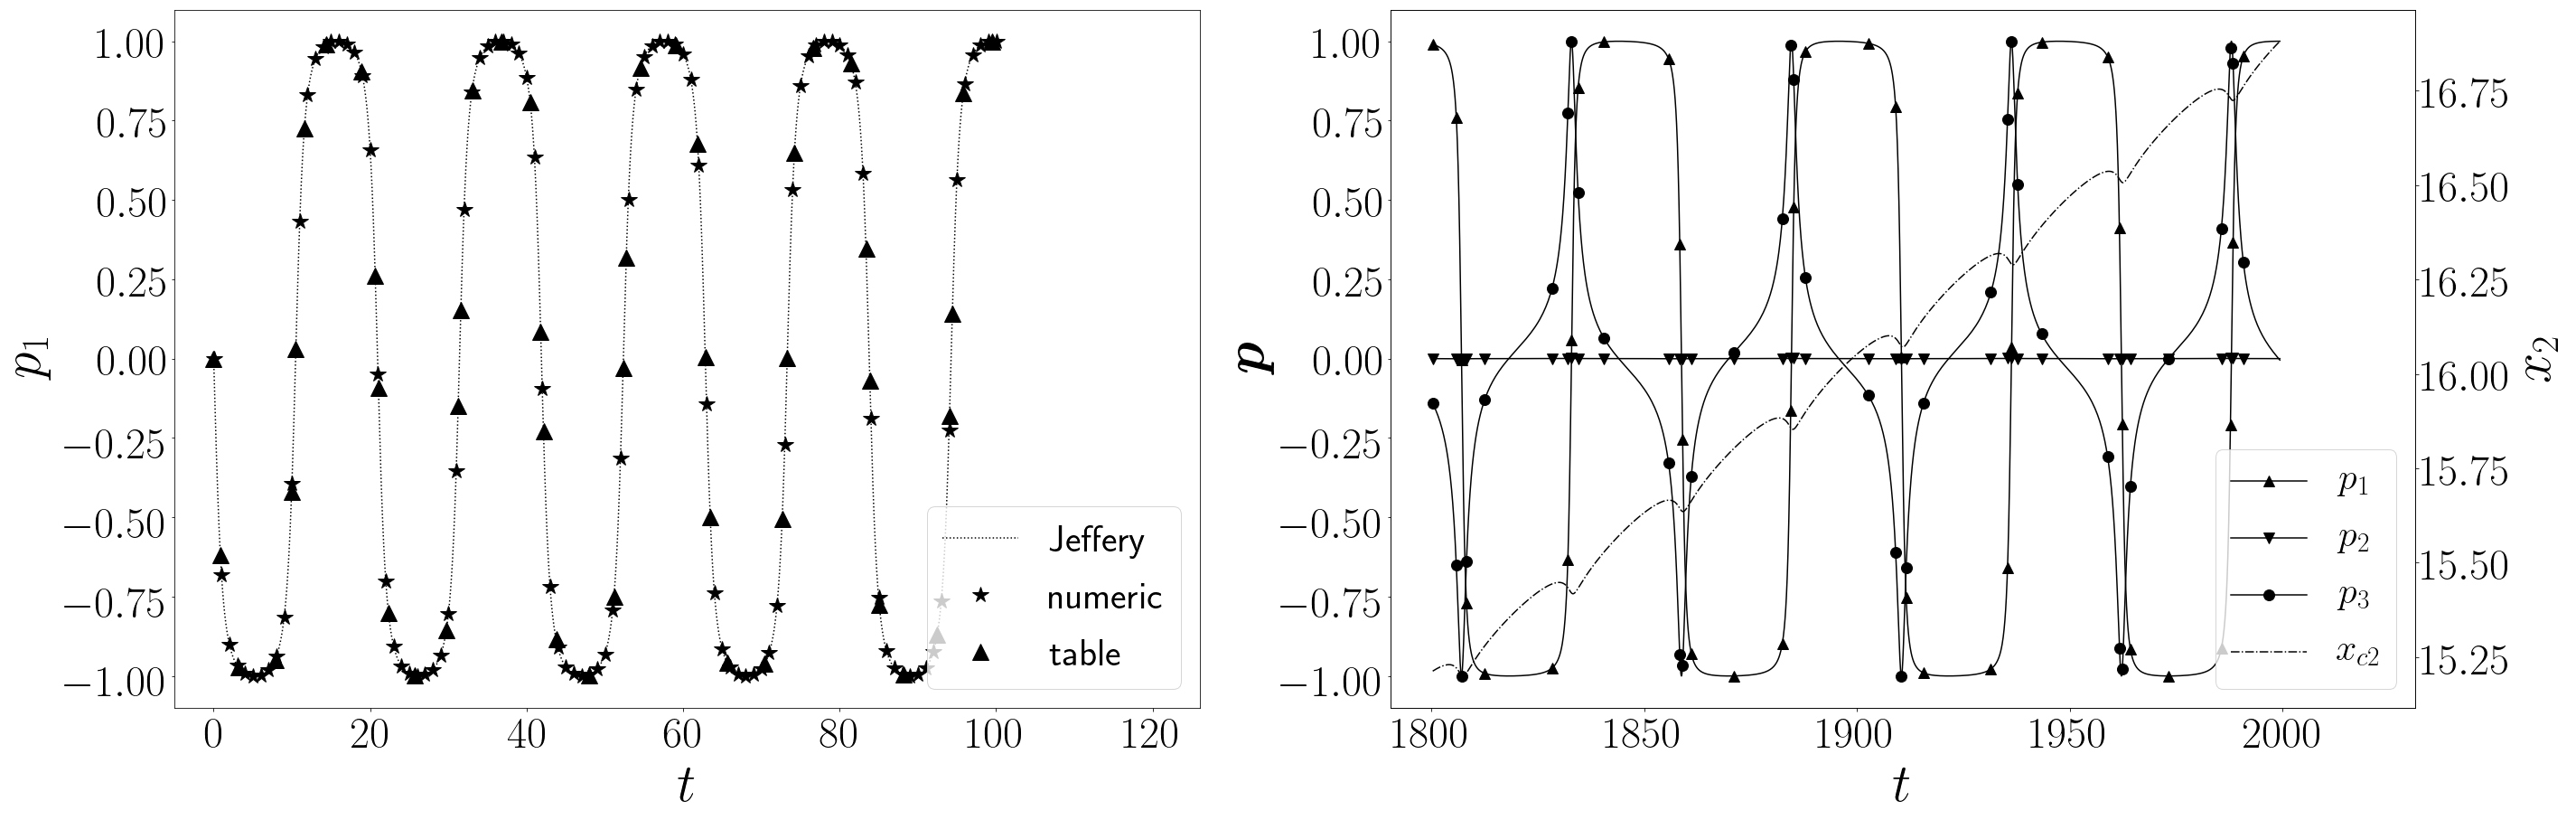

In [4]:
%matplotlib inline
importlib.reload(jm)
importlib.reload(spf_tb)
fontsize = 60
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(40, 13))
fig.patch.set_facecolor('white')

########################################################################################################
# left part, jeffery case
fileHandle = 'ShearJefferyProblem'
job_dir = 'head_shear2'
job_name = 'eq_theta1.562_phi6.272'
talpha = 3
ellipse_velocity = 0
planeShearRate = (1, 0, 0)

# load simulation results. 
mat_path = os.path.join(PWD, job_dir, job_name)
mat_contents = loadmat(mat_path)
ecoli_center = mat_contents['ecoli_center']
ecoli_norm = mat_contents['ecoli_norm']
ecoli_U = mat_contents['ecoli_U']
eval_t = mat_contents['t'].flatten()
ecoli_t = eval_t
eval_dt = np.mean(np.diff(eval_t))
max_iter = eval_t.size
problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
tnorm = ecoli_norm[0]
tnorm = tnorm / np.linalg.norm(tnorm)
tcenter = ecoli_center[0]
lateral_norm = np.array((1, 0, 0))
lateral_norm = lateral_norm - tnorm / np.linalg.norm(tnorm) * np.dot(tnorm, lateral_norm) / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)

ellipse_kwargs = {'name':     job_name,
                  'center':   tcenter,
                  'norm':     tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed': ellipse_velocity,
                  'lbd':      (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
problem.add_obj(ellipse_obj)

# jeffery results, evaluation loop
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))
jeffery_t = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)

# table results. 
t_psi = 0
max_t = max_iter * eval_dt
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_ellipse_Petsc4n(tnorm, t_psi, max_t)

ax0.plot(jeffery_t, norm_hist[:, 0], ':k', label='Jeffery')
# ax0.plot(jeffery_t, norm_hist[:, 1], '-.k', label='Jeffery, $p_2$')
# ax0.plot(jeffery_t, norm_hist[:, 2], '--k', label='Jeffery, $p_3$')
markevery = ecoli_t.size // 100
ax0.plot(ecoli_t, ecoli_norm[:, 0], '*k', label='numeric', markersize=fontsize*0.3, markevery=markevery)
# ax0.plot(ecoli_t, ecoli_norm[:, 1], '.k', label='numeric, $p_2$', markersize=fontsize*0.3, markevery=markevery * 5)
# ax0.plot(ecoli_t, ecoli_norm[:, 2], '^k', label='numeric, $p_3$', markersize=fontsize*0.3, markevery=markevery)
ax0.plot(Table_t, Table_P[:, 0], '^k', label='table', markersize=fontsize*0.3, markevery=markevery // 3)
plt.sca(ax0)
ax0.set_xlabel('$t$', size=fontsize)
ax0.set_ylabel('$p_1$', size=fontsize)
ax0.legend(fontsize=fontsize*0.7, loc=4)
ax0.set_xlim(ax0.get_xlim()[0], ax0.get_xlim()[1] * 1.2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

######################################################################################################
#right part, helix case
tnorm = np.array((0, 0, 1))
t_psi = 0
max_t = 2000
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_helix_Petsc4n(tnorm, t_psi, max_t)
tidx = Table_t > 1800
markevery = np.sum(tidx) // 37
markersize = fontsize*0.2
ax1.plot(Table_t[tidx], Table_P[tidx, 0], '-^k', label='$p_1$', markevery=markevery, markersize=markersize)
ax1.plot(Table_t[tidx], Table_P[tidx, 1], '-vk', label='$p_2$', markevery=markevery, markersize=markersize)
ax1.plot(Table_t[tidx], Table_P[tidx, 2], '-ok', label='$p_3$', markevery=markevery, markersize=markersize)
ax1.plot([np.nan], [np.nan], '-.k', label='$x_{c2}$', markevery=markevery, markersize=markersize)
plt.sca(ax1)
ax1.set_xlabel('$t$', size=fontsize)
ax1.set_ylabel('$\\bm{p}$', size=fontsize)
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[0] + (ax1.get_xlim()[1] - ax1.get_xlim()[0]) * 1.1)
ax1.legend(fontsize=fontsize*0.7, loc=4)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

ax2 = ax1.twinx()
ax2.plot(Table_t[tidx], Table_X[tidx, 1], '-.k', label='$y$', markevery=markevery, markersize=markersize)
plt.sca(ax2)
ax2.set_ylabel('$x_2$', size=fontsize)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

In [3]:
0.2864874730919643 /  193.66627834

0.0014792842385756373

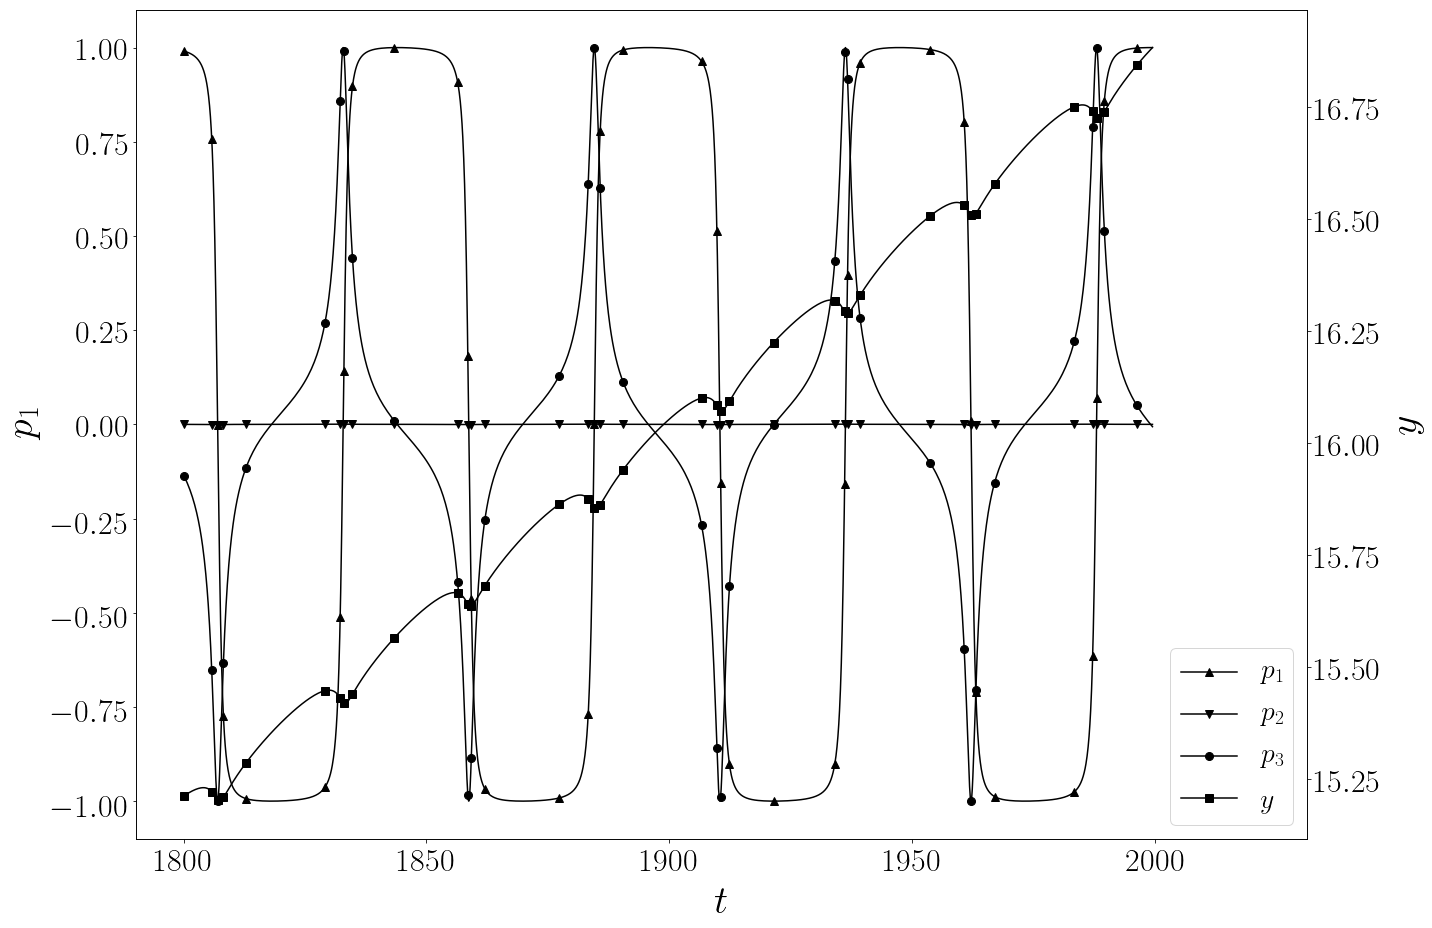

In [3]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 13))
fig.patch.set_facecolor('white')
tnorm = np.array((0, 0, 1))
t_psi = 0
max_t = 2000
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_helix_Petsc4n(tnorm, t_psi, max_t)
tidx = Table_t > 1800
markevery = np.sum(tidx) // 37
markersize = fontsize*0.2
ax1.plot(Table_t[tidx], Table_P[tidx, 0], '-^k', label='$p_1$', markevery=markevery, markersize=markersize)
ax1.plot(Table_t[tidx], Table_P[tidx, 1], '-vk', label='$p_2$', markevery=markevery, markersize=markersize)
ax1.plot(Table_t[tidx], Table_P[tidx, 2], '-ok', label='$p_3$', markevery=markevery, markersize=markersize)
ax1.plot([np.nan], [np.nan], '-sk', label='$y$', markevery=markevery, markersize=markersize)
plt.sca(ax1)
ax1.set_xlabel('$t$', size=fontsize)
ax1.set_ylabel('$p_1$', size=fontsize)
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[0] + (ax1.get_xlim()[1] - ax1.get_xlim()[0]) * 1.1)
ax1.legend(fontsize=fontsize*0.7, loc=4)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

ax2 = ax1.twinx()
ax2.plot(Table_t[tidx], Table_X[tidx, 1], '-sk', label='$y$', markevery=markevery, markersize=markersize)
plt.sca(ax2)
ax2.set_ylabel('$y$', size=fontsize)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()


In [5]:
0.019882410135194976 / 193.66260319

0.00010266520127114365